In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from numpy import matlib as mb
import cv2
import os
from tqdm import tqdm
from scipy.interpolate import RectBivariateSpline

# Object Tracking using Lucas Kanade 

In [20]:
video=cv2.VideoCapture(r"C:\Users\balub\Downloads\win-20230313-00-12-25-pro_fd9J0zqI.mp4")
fps = video.get(cv2.CAP_PROP_FPS)
frames=[]
while True:
    ret,frame=video.read()
    if not ret:
        break
    frames.append(frame)
frames = np.array(frames)

In [21]:
frames.shape

(261, 200, 200, 3)

In [22]:
fps

20.0

In [23]:
gray_frames = []
for frame in frames:
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    gray_frames.append(gray_frame)
gray_frames=np.array(gray_frames)
frames=gray_frames

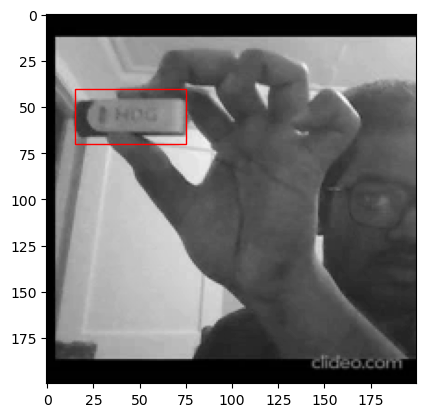

In [24]:
It1=gray_frames[0,:,:]
plt.figure()
currentAxis = plt.gca()
rect = [15,40,75,70]
w=rect[2]-rect[0]
h=rect[3]-rect[1]
rect_draw_It1 = patches.Rectangle((rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
currentAxis.add_patch(rect_draw_It1)
plt.imshow(It1, cmap='gray')

In [25]:
def LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2)):
     # Initialize p to p0
    p = p0
    delta_p = np.ones((1,2))

    x1,y1,x2,y2=rect
    w,h=int(x2-x1),int(y2-y1)
    rbs0=RectBivariateSpline(np.arange(0,It.shape[0],1),np.arange(0,It.shape[1],1),It)
    rbs1=RectBivariateSpline(np.arange(0,It1.shape[0],1),np.arange(0,It1.shape[1],1),It1)
    change=1
    num_iters=int(num_iters)
    X,Y=np.mgrid[x1:x2+1:w*1j,y1:y2+1:h*1j]
    for ite in range(int(num_iters)):
        if change>threshold:
            px1=rbs1.ev(p[1]+Y,p[0]+X,dy=1).flatten()
            py1=rbs1.ev(p[1]+Y,p[0]+X,dx=1).flatten()
            A=np.zeros((w*h,2*w*h))
            for i in range(w*h):
                A[i,2*i],A[i,2*i+1]=px1[i],py1[i]
            delta_p,_,_,_=np.linalg.lstsq(np.matmul(A,mb.repmat(np.eye(2),w*h,1)),np.reshape(rbs0.ev(Y,X).flatten()-rbs1.ev(p[1]+Y,p[0]+X).flatten(),(w*h,1)),rcond=None)
            change=np.linalg.norm(delta_p)
            p=(p+delta_p.T).ravel()
        else:
            break
    return p

In [26]:
def TrackSequence(seq, rect, num_iters, threshold):
    H, W, N = seq.shape
    rects =[rect]
    It = seq[0, :, :]
    for i in tqdm(range(1, seq.shape[0])):
        p =LucasKanade(seq[i-1,:,:],seq[i,:,:],rect, threshold, num_iters)
        rect=[rect[0]+p[0],rect[1]+p[1],rect[2]+p[0],rect[3]+p[1]]
        rects.append(rect)
    rects = np.array(rects)
    assert rects.shape == (H, 4), f"Your output sequence {rects.shape} is not {N}x{4}"
    return rects

In [27]:
seq = frames
rect = [15,40,75,70]
num_iters = 1e4
threshold = 1e-2
rects = TrackSequence(seq, rect, num_iters, threshold)
np.save(r"C:/Users/balub/OneDrive/Desktop/CV HW2/extracredit.npy", rects)

100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [00:18<00:00, 14.10it/s]


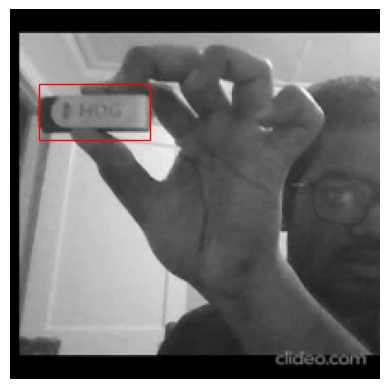

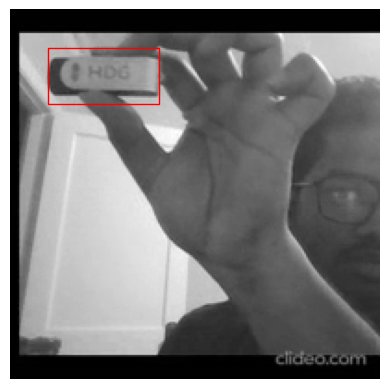

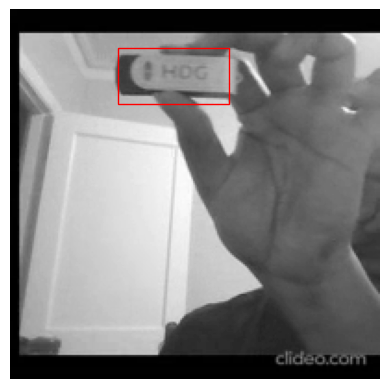

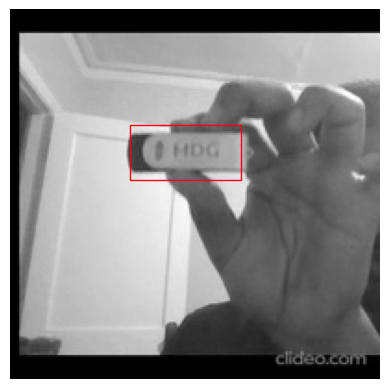

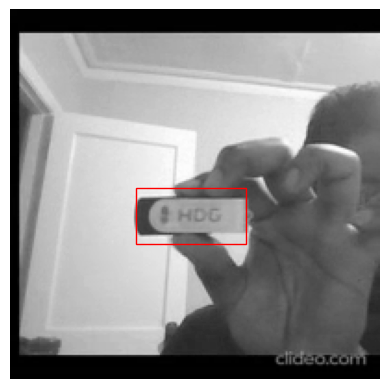

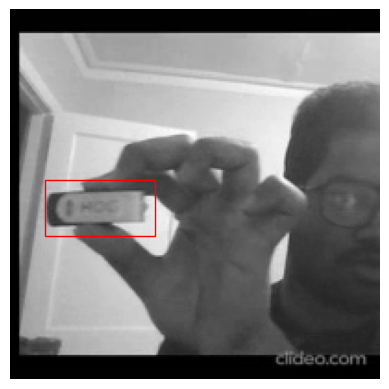

In [35]:
frames_to_save = [int(fps*n)+1 for n in range(0,6)]

for idx in frames_to_save:
    frame = seq[idx-1,:,:]
    rect=rects[idx-1,:]
    w=rect[2]-rect[0]
    h = rect[3]-rect[1]
    plt.figure()
    axis = plt.gca()
    rect_draw = patches.Rectangle(
        (rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    axis.add_patch(rect_draw)
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"C:/Users/balub/OneDrive/Desktop/CV HW2/extracredit_images/sol_3.2_pendrive_frame at {idx-1}s.png")